In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx_gdf import read_gdf
from networkx.algorithms.community import label_propagation_communities
import networkx.algorithms.community as nx_comm
import pandas as pd
import random
from itertools import combinations


# Pregunta 1

In [2]:
def calcular_fiedler(matriz_adyacencia):
    A = np.array(matriz_adyacencia)
    D = np.diag(A.sum(axis=1))
    L = D - A

    valores_propios, vectores_propios = np.linalg.eig(L)
    
    indices_ordenados = np.argsort(valores_propios)
    valores_propios_ordenados = valores_propios[indices_ordenados]
    vectores_propios_ordenados = vectores_propios[:, indices_ordenados]
    
    valor_de_fiedler = valores_propios_ordenados[1]
    vector_propio_fiedler = vectores_propios_ordenados[:, 1]
    y = L.view
    
    return valor_de_fiedler, vector_propio_fiedler

In [3]:
Ady = [
    [0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 0]
]

valor_de_fiedler, vector_propio_fiedler = calcular_fiedler(Ady)
print("El valor de Fiedler es:", valor_de_fiedler)
print("El vector propio asociado es:", vector_propio_fiedler)

El valor de Fiedler es: 0.34032095848177074
El vector propio asociado es: [-0.46724728 -0.46724728 -0.30823323  0.11469308  0.27370712  0.33957289
  0.5147547 ]


In [4]:
np.set_printoptions(precision=2, suppress=True, linewidth=100)
A = np.array(Ady)
D = np.diag(A.sum(axis=1))
L = D - A
print(L)

[[ 2 -1 -1  0  0  0  0]
 [-1  2 -1  0  0  0  0]
 [-1 -1  3 -1  0  0  0]
 [ 0  0 -1  3 -1 -1  0]
 [ 0  0  0 -1  2 -1  0]
 [ 0  0  0 -1 -1  3 -1]
 [ 0  0  0  0  0 -1  1]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


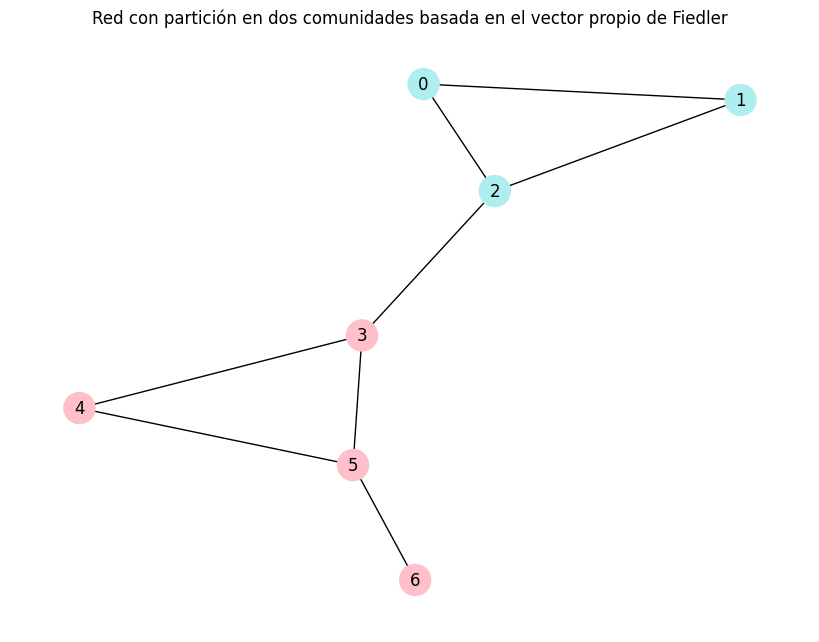

In [5]:
G = nx.from_numpy_array(A)

color_map = []
for value in vector_propio_fiedler:
    if value < 0:
        color_map.append('paleturquoise')
    else:
        color_map.append('pink')


pos = nx.spring_layout(G)  
plt.figure(figsize=(8, 6))

nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, cmap=plt.cm.coolwarm)


plt.title('Red con partición en dos comunidades basada en el vector propio de Fiedler')
plt.show()

# Pregunta 3

In [6]:
gnutella = read_gdf("Datos/gnutella.gdf")
delfines = nx.read_pajek("Datos/delfines.net")

In [7]:
def giant_component_size(G):
    return len(max(nx.connected_components(G), key=len))

def remove_nodes_random_recalc(G):
    G_copy = G.copy()
    initial_size = giant_component_size(G_copy)
    target_size = initial_size / 2
    nodes = list(G.nodes)
    random.shuffle(nodes)
    removed_nodes = 0
    while giant_component_size(G_copy) > target_size and nodes:
        node = nodes.pop()
        G_copy.remove_node(node)
        removed_nodes += 1
    return removed_nodes, G_copy

def remove_nodes_degree_recalc(G):
    G_copy = G.copy()
    initial_size = giant_component_size(G_copy)
    target_size = initial_size / 2
    removed_nodes = 0
    while giant_component_size(G_copy) > target_size and len(G.nodes) > 0:
        degrees = nx.degree(G_copy)
        node = max(degrees, key=lambda x: x[1])[0]
        G_copy.remove_node(node)
        removed_nodes += 1
    return removed_nodes, G_copy

def remove_nodes_betweenness_recalc(G):
    G_copy = G.copy()
    initial_size = giant_component_size(G_copy)
    target_size = initial_size / 2
    removed_nodes = 0
    while giant_component_size(G_copy) > target_size and len(G_copy.nodes) > 0:
        betweenness = nx.betweenness_centrality(G_copy)
        node = max(betweenness, key=betweenness.get)
        G_copy.remove_node(node)
        removed_nodes += 1
    return removed_nodes, G_copy

def generate_er_network(G):
    n = G.number_of_nodes()
    p = nx.density(G)
    return nx.erdos_renyi_graph(n, p)

er_gnutella = generate_er_network(gnutella)
er_delfines = generate_er_network(delfines)

networks = {
    "Gnutella": gnutella,
    "Delfines": delfines,
    "Erdos-Rényi Gnutella": er_gnutella,
    "Erdos-Rényi Delfines": er_delfines
}

for name, G in networks.items():
    initial_nodes = G.number_of_nodes()
    
    random_removed, _ = remove_nodes_random_recalc(G)
    degree_removed, _ = remove_nodes_degree_recalc(G)
    betweenness_removed, _ = remove_nodes_betweenness_recalc(G)
    
    print(f"{name}:")
    print(f"  Nodos iniciales: {initial_nodes}")
    print(f"  Eliminación aleatoria: {random_removed} nodos ({random_removed/initial_nodes:.2%})")
    print(f"  Eliminación por grado: {degree_removed} nodos ({degree_removed/initial_nodes:.2%})")
    print(f"  Eliminación por betweenness: {betweenness_removed} nodos ({betweenness_removed/initial_nodes:.2%})\n")

Gnutella:
  Nodos iniciales: 795
  Eliminación aleatoria: 263 nodos (33.08%)
  Eliminación por grado: 24 nodos (3.02%)
  Eliminación por betweenness: 25 nodos (3.14%)

Delfines:
  Nodos iniciales: 62
  Eliminación aleatoria: 28 nodos (45.16%)
  Eliminación por grado: 15 nodos (24.19%)
  Eliminación por betweenness: 8 nodos (12.90%)

Erdos-Rényi Gnutella:
  Nodos iniciales: 795
  Eliminación aleatoria: 243 nodos (30.57%)
  Eliminación por grado: 68 nodos (8.55%)
  Eliminación por betweenness: 41 nodos (5.16%)

Erdos-Rényi Delfines:
  Nodos iniciales: 62
  Eliminación aleatoria: 30 nodos (48.39%)
  Eliminación por grado: 22 nodos (35.48%)
  Eliminación por betweenness: 19 nodos (30.65%)



# Pregunta 4 (posible ?)

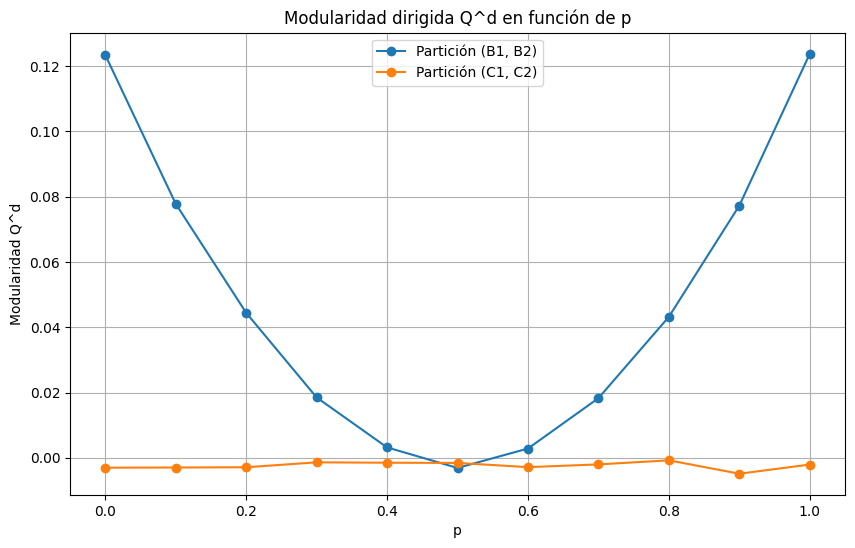

In [8]:
# Parámetros del experimento
n = 200
p_connect = 0.2
p_values = np.arange(0, 1.1, 0.1)
num_realizations = 50

# Particiones
B1 = set(range(100))
B2 = set(range(100, 200))
C1 = set(range(50)).union(set(range(100, 150)))
C2 = set(range(50, 100)).union(set(range(150, 200)))

def orient_edges_randomly(G, p, B1, B2):
    directed_G = nx.DiGraph()
    directed_G.add_nodes_from(G.nodes())
    
    for u, v in G.edges():
        if (u in B1 and v in B2) or (u in B2 and v in B1):
            if np.random.rand() < p:
                directed_G.add_edge(u, v)
            else:
                directed_G.add_edge(v, u)
        else:
            if np.random.rand() < 0.5:
                directed_G.add_edge(u, v)
            else:
                directed_G.add_edge(v, u)
    
    return directed_G

def calculate_modularity_directed(G, partition):
    m = G.number_of_edges()
    modularity = 0.0
    partition_map = {node: idx for idx, community in enumerate(partition) for node in community}
    
    for community in partition:
        for i in community:
            d_i_out = G.out_degree(i)
            for j in community:
                A_ij = 1 if G.has_edge(i, j) else 0
                d_j_in = G.in_degree(j)
                modularity += (A_ij - (d_i_out * d_j_in) / m) * (partition_map[i] == partition_map[j])
    
    modularity /= m
    return modularity

# Resultados de modularidad
Qd_B = np.zeros(len(p_values))
Qd_C = np.zeros(len(p_values))

for i, p in enumerate(p_values):
    Qd_B_realizations = []
    Qd_C_realizations = []
    
    for _ in range(num_realizations):
        # Generar grafo ER
        G = nx.erdos_renyi_graph(n, p_connect)
        
        # Orientar aristas
        directed_G = orient_edges_randomly(G, p, B1, B2)
        
        # Calcular modularidad para particiones B y C
        partition_B = [B1, B2]
        partition_C = [C1, C2]
        
        Qd_B_realizations.append(calculate_modularity_directed(directed_G, partition_B))
        Qd_C_realizations.append(calculate_modularity_directed(directed_G, partition_C))
    
    Qd_B[i] = np.mean(Qd_B_realizations)
    Qd_C[i] = np.mean(Qd_C_realizations)

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(p_values, Qd_B, label = "Partición (B1, B2)", marker = "o")
plt.plot(p_values, Qd_C, label = "Partición (C1, C2)", marker = "o")
plt.xlabel("p")
plt.ylabel("Modularidad Q^d")
plt.title("Modularidad dirigida Q^d en función de p")
plt.legend()
plt.grid(True)
plt.show()



# Pregunta 6

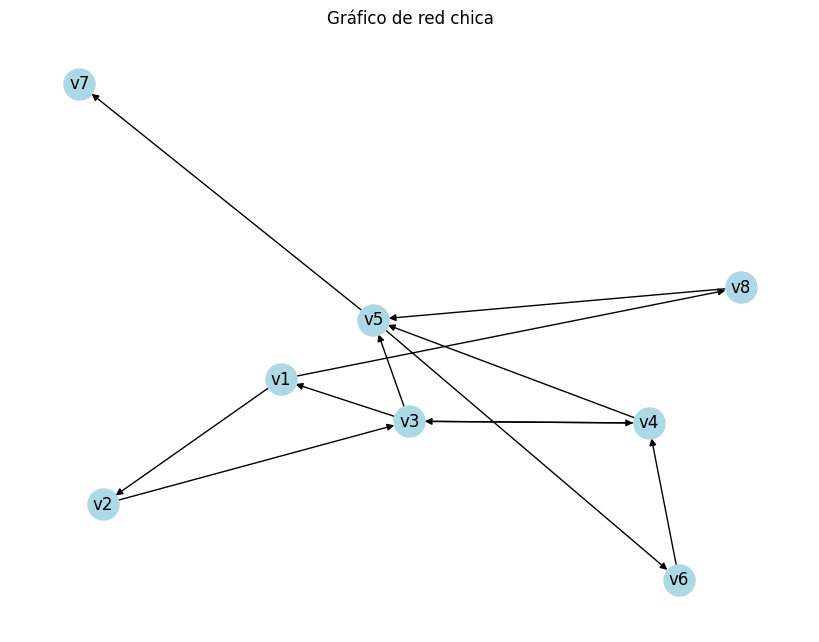

In [9]:
# Builds NetworkX graph object from file.
G6 = read_gdf("Datos/redchica.gdf")

pos = nx.spring_layout(G6)
plt.figure(figsize=(8, 6))

nx.draw(G6, pos, with_labels=True, node_size=500, node_color="lightblue")

plt.title("Gráfico de red chica")
plt.show()

In [10]:
in_degree = dict(G6.in_degree())
betweenness = nx.betweenness_centrality(G6)
pagerank = nx.pagerank(G6)

df = pd.DataFrame({
    'Node': list(G6.nodes()),
    'In-Degree': [in_degree[node] for node in G6.nodes()],
    'Betweenness': [betweenness[node] for node in G6.nodes()],
    'PageRank': [pagerank[node] for node in G6.nodes()]
})
df

,Node,In-Degree,Betweenness,PageRank
0,v1,1,0.238095,0.077725
1,v2,1,0.047619,0.064579
2,v3,2,0.428571,0.162980
3,v4,2,0.309524,0.180098
4,v5,3,0.357143,0.209159
5,v6,1,0.214286,0.120440
6,v7,1,0.000000,0.120440
7,v8,1,0.071429,0.064579


# Pregunta 7

In [14]:
scientometrics = nx.read_pajek("Datos/scientometrics.net")
scientometrics = nx.DiGraph(scientometrics)

print("Número de nodos: ", scientometrics.number_of_nodes())
print("Número de aristas: ", scientometrics.number_of_edges())

scientometrics = nx.to_undirected(scientometrics)
print(nx.triangles(scientometrics, nodes=None))

Número de nodos:  1656
Número de aristas:  4123
{'1': 1, '2': 0, '3': 0, '4': 0, '5': 0, '6': 24, '7': 0, '8': 0, '9': 0, '10': 17, '11': 0, '12': 11, '13': 0, '14': 0, '15': 0, '16': 0, '17': 6, '18': 0, '19': 0, '20': 0, '21': 2, '22': 0, '23': 16, '24': 8, '25': 0, '26': 0, '27': 0, '28': 8, '29': 0, '30': 4, '31': 4, '32': 1, '33': 0, '34': 0, '35': 0, '36': 0, '37': 2, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 0, '44': 0, '45': 0, '46': 0, '47': 0, '48': 0, '49': 0, '50': 0, '51': 0, '52': 3, '53': 0, '54': 0, '55': 0, '56': 0, '57': 0, '58': 0, '59': 0, '60': 1, '61': 0, '62': 0, '63': 0, '64': 0, '65': 10, '66': 0, '67': 1, '68': 1, '69': 0, '70': 1, '71': 0, '72': 0, '73': 0, '74': 4, '75': 0, '76': 2, '77': 0, '78': 14, '79': 35, '80': 0, '81': 0, '82': 2, '83': 0, '84': 33, '85': 0, '86': 0, '87': 5, '88': 19, '89': 0, '90': 0, '91': 1, '92': 3, '93': 0, '94': 5, '95': 3, '96': 0, '97': 8, '98': 8, '99': 3, '100': 0, '101': 0, '102': 1, '103': 2, '104': 4, '105': 0, 

# Pregunta 8

In [20]:
n = 50
m = 50

# posicion grilla a id
def index_to_node(i, j):
    return i * m + j

# nodo a posicion grilla
def node_to_index(node):
    return (node / m, node % m)

def init_graph(n, m):
    # grafo vacio
    G = nx.Graph()
    # genero grilla inicial
    for i in range(n):
        for j in range(m):
            node = index_to_node(i, j)
            # arriba
            if i > 0:
                v = index_to_node(i - 1, j)
                
                if not G.has_edge(node, v):
                    G.add_edge(node, v)
            # abajo
            if i < 49:
                v = index_to_node(i + 1, j)
                
                if not G.has_edge(node, v):
                    G.add_edge(node, v)
            # derecha
            if j < 49:
                v = index_to_node(i, j + 1)
                
                if not G.has_edge(node, v):
                    G.add_edge(node, v)
            # izquierda
            if j > 0:
                v = index_to_node(i, j - 1)
                
                if not G.has_edge(node, v):
                    G.add_edge(node, v)
    return G

In [21]:
# dado una lista de vecino elige uno al azar asumiendo que todos tienen la misma probabilidad
def random_neighbor(neighbors):
    x = np.random.rand()
    for i in range(1, len(neighbors) + 1):
        if x < i * 1 / len(neighbors):
            return neighbors[i - 1]

In [22]:
def extra(p, n, m):
    G = init_graph(n, m)
    for i in range(n):
        for j in range(m):
            # comienzo de procedimiento
            node = index_to_node(i, j)
            actual_node = node
            steps = 0
            while True:
                # tomo la posicion en la grilla del nodo actual
                act_i, act_j = node_to_index(actual_node)
                dirs = []
                # aqui se agregan sus posibles nodos vecinos
                if act_i > 0:
                    dirs.append(index_to_node(act_i - 1, act_j))
                if act_j > 0:
                    dirs.append(index_to_node(act_i, act_j - 1))
                if act_i < n - 1:
                    dirs.append(index_to_node(act_i + 1, act_j))
                if act_j < m - 1:
                    dirs.append(index_to_node(act_i, act_j + 1))

                # se elige al azar
                next_node = random_neighbor(dirs)
                x = np.random.rand()
                if x < p:
                    # fin de procedimiento, gracias a la implementación si la arista existe no hace nada
                    G.add_edge(node, next_node)
                    break
                actual_node = next_node
    return G

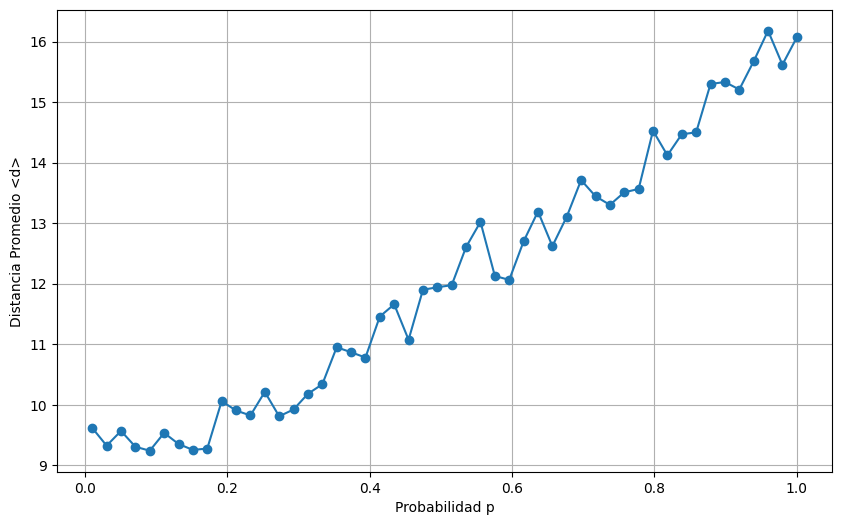

In [33]:
ps = np.linspace(0.01, 1, 50)
average_distances = []
for p in ps:
    G = extra(p, n, m)
    average_distances.append(nx.average_shortest_path_length(G))


# Graficar
plt.figure(figsize=(10, 6))
plt.plot(ps, average_distances, marker='o')
plt.xlabel('Probabilidad p')
plt.ylabel('Distancia Promedio <d>')
plt.grid(True)
plt.show()